In [7]:
spark

In [2]:
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("FlightDataAnalysis") \
    .getOrCreate()

In [11]:
spark

In [4]:
# 1. Read File
df = spark.read.csv("/home/jovyan/work/files/data/2015-summary.csv", header=True, inferSchema=True)
df.show(5)

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|    United States|            Romania|   15|
|    United States|            Croatia|    1|
|    United States|            Ireland|  344|
|            Egypt|      United States|   15|
|    United States|              India|   62|
+-----------------+-------------------+-----+
only showing top 5 rows



Each of these DataFrames (in Scala and Python) have a set of columns with an unspecified number of rows. The reason the number of rows is unspecified is because reading data is a transformation, and is therefore a lazy operation.

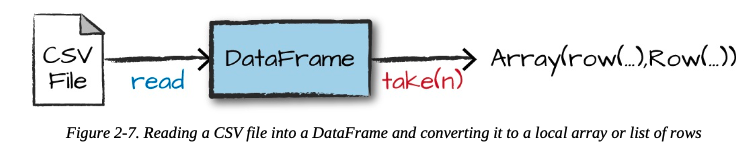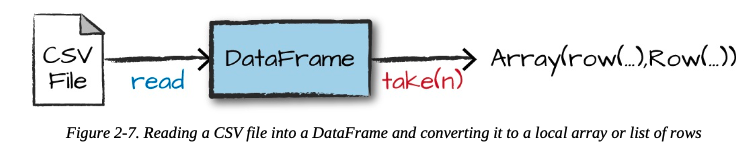

In [7]:
df.take(10)

[Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Romania', count=15),
 Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Croatia', count=1),
 Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Ireland', count=344),
 Row(DEST_COUNTRY_NAME='Egypt', ORIGIN_COUNTRY_NAME='United States', count=15),
 Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='India', count=62),
 Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Singapore', count=1),
 Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Grenada', count=62),
 Row(DEST_COUNTRY_NAME='Costa Rica', ORIGIN_COUNTRY_NAME='United States', count=588),
 Row(DEST_COUNTRY_NAME='Senegal', ORIGIN_COUNTRY_NAME='United States', count=40),
 Row(DEST_COUNTRY_NAME='Moldova', ORIGIN_COUNTRY_NAME='United States', count=1)]

In [8]:
# Sort Our Data According to count Column

df.sort("count")

DataFrame[DEST_COUNTRY_NAME: string, ORIGIN_COUNTRY_NAME: string, count: int]

Sort does not modify the DataFrame. We use sort as a transformation that returns a new DataFrame by transforming the previous DataFrame

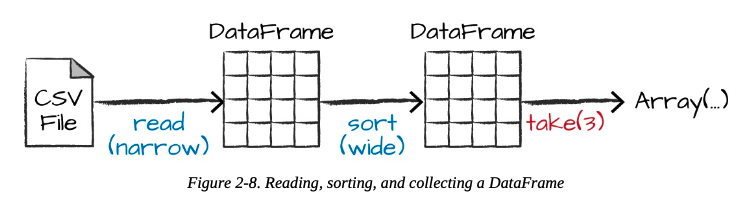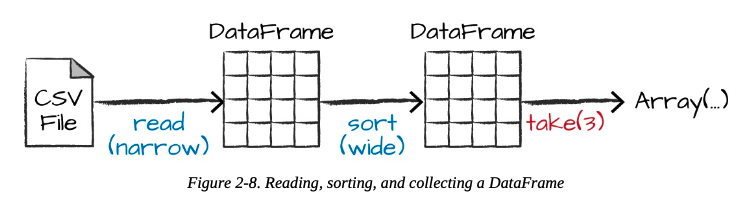

Nothing happens to the data when we call sort because it’s just a transformation.

However, we can see that Spark is building up a plan for how it will execute this across the cluster by looking at the explain plan.

In [9]:
df.sort("count").explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Sort [count#19 ASC NULLS FIRST], true, 0
   +- Exchange rangepartitioning(count#19 ASC NULLS FIRST, 200), ENSURE_REQUIREMENTS, [plan_id=57]
      +- FileScan csv [DEST_COUNTRY_NAME#17,ORIGIN_COUNTRY_NAME#18,count#19] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/home/jovyan/work/files/data/2015-summary.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<DEST_COUNTRY_NAME:string,ORIGIN_COUNTRY_NAME:string,count:int>




In [10]:
# 3.  Perform Action

df.sort("count").take(3)

[Row(DEST_COUNTRY_NAME='Moldova', ORIGIN_COUNTRY_NAME='United States', count=1),
 Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Croatia', count=1),
 Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Singapore', count=1)]

## DataFrame and SQL 

Spark can run the same transformations, regardless of the language, in the exact same way.

You can express your business logic in SQL or DataFrames (either in R, Python, Scala, or Java) and Spark will compile that logic down to an underlying plan (that you can see in the explain plan) before actually executing your code.

In [11]:
# create table view 

df.createOrReplaceTempView("df")

Now we can query our data in SQL.

In [18]:
sqlWay = spark.sql("""
  SELECT DEST_COUNTRY_NAME, count(1)
  FROM df
  GROUP BY DEST_COUNTRY_NAME
  """)

sqlWay.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[DEST_COUNTRY_NAME#17], functions=[count(1)])
   +- Exchange hashpartitioning(DEST_COUNTRY_NAME#17, 200), ENSURE_REQUIREMENTS, [plan_id=79]
      +- HashAggregate(keys=[DEST_COUNTRY_NAME#17], functions=[partial_count(1)])
         +- FileScan csv [DEST_COUNTRY_NAME#17] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/home/jovyan/work/files/data/2015-summary.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<DEST_COUNTRY_NAME:string>




In [21]:
  dateFrameWay = df.groupBy("DEST_COUNTRY_NAME").count()

  dateFrameWay.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[DEST_COUNTRY_NAME#17], functions=[count(1)])
   +- Exchange hashpartitioning(DEST_COUNTRY_NAME#17, 200), ENSURE_REQUIREMENTS, [plan_id=92]
      +- HashAggregate(keys=[DEST_COUNTRY_NAME#17], functions=[partial_count(1)])
         +- FileScan csv [DEST_COUNTRY_NAME#17] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/home/jovyan/work/files/data/2015-summary.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<DEST_COUNTRY_NAME:string>




In [24]:
spark.sql("SELECT max(count) from df").take(1)



[Row(max(count)=370002)]

OR

In [26]:
from pyspark.sql.functions import max
df.select(max("count")).take(1)

[Row(max(count)=370002)]

In [27]:
  maxSql = spark.sql("""
  SELECT DEST_COUNTRY_NAME, sum(count) as destination_total
  FROM df
  GROUP BY DEST_COUNTRY_NAME
  ORDER BY sum(count) DESC
  LIMIT 5
  """)

  maxSql.show()

+-----------------+-----------------+
|DEST_COUNTRY_NAME|destination_total|
+-----------------+-----------------+
|    United States|           411352|
|           Canada|             8399|
|           Mexico|             7140|
|   United Kingdom|             2025|
|            Japan|             1548|
+-----------------+-----------------+



In [28]:
from pyspark.sql.functions import desc

df\
    .groupBy("DEST_COUNTRY_NAME")\
    .sum("count")\
    .withColumnRenamed("sum(count)", "destination_total")\
    .sort(desc("destination_total"))\
    .limit(5)\
    .show()

+-----------------+-----------------+
|DEST_COUNTRY_NAME|destination_total|
+-----------------+-----------------+
|    United States|           411352|
|           Canada|             8399|
|           Mexico|             7140|
|   United Kingdom|             2025|
|            Japan|             1548|
+-----------------+-----------------+



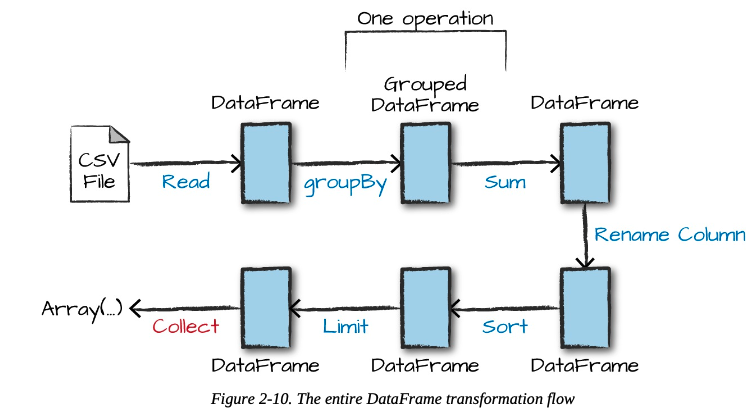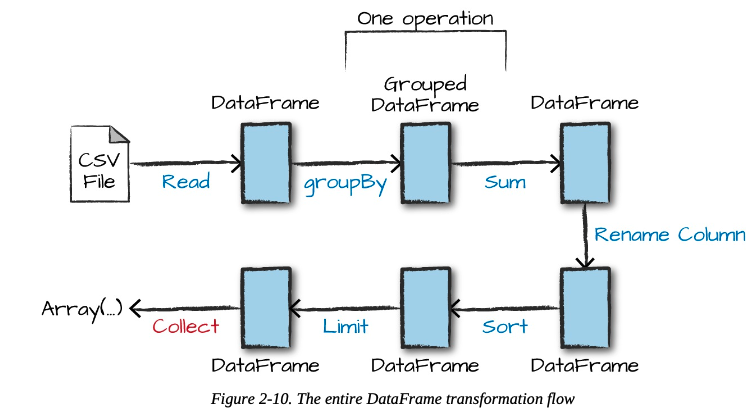